In [30]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn, optim

# Definimos las transformaciones para normalizar los datos
# Las imágenes originales están en escala de grises con valores entre 0.0 y 1.0
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertimos imágenes a Tensores
    transforms.Normalize((0.5,), (0.5,))  # Normalizamos con media 0.5 y desviación estándar 0.5
])

# Cargamos el dataset MNIST
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print("Máximo valor de la imagen:", train_data[0][0].squeeze().max())
print("Mínimo valor de la imagen:",train_data[0][0].squeeze().min())

# DataLoader para los conjuntos de entrenamiento y prueba
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

Máximo valor de la imagen: tensor(1.)
Mínimo valor de la imagen: tensor(-1.)


1.0 -1.0
1.0 0.0


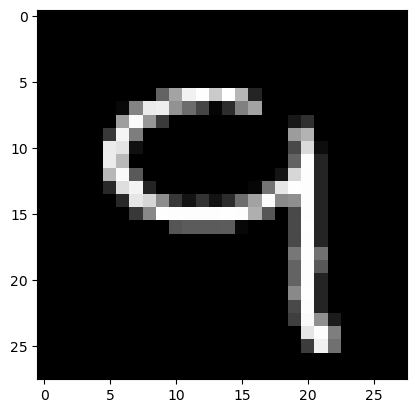

In [31]:
# Vamos a visualizar una imagen del dataset
import matplotlib.pyplot as plt
import numpy as np

# Obtenemos una imagen del dataset
dataiter = iter(train_loader)
images, labels = next(dataiter)

#Variables para la predicción
single_label = labels[0]
single_image = images[0]

# Convertimos la imagen a numpy y "desaplanamos"/redimensionamos si es necesario
# Además, deshacemos la normalización aplicada previamente
image = images[0].numpy().squeeze()  # Eliminamos dimensiones de tamaño 1

print(image.max(), image.min())
image = (image * 0.5) + 0.5  # Deshacemos la normalización
print(image.max(), image.min())

# Visualizamos la imagen
plt.imshow(image, cmap='gray')
plt.show()

In [32]:
for images, labels in train_loader:
    print("Tamaño del batch de imágenes:", images.shape)
    print("Tamaño del batch de etiquetas:", labels.shape)
    break

Tamaño del batch de imágenes: torch.Size([64, 1, 28, 28])
Tamaño del batch de etiquetas: torch.Size([64])


In [33]:
#Definimos el modelo
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        # Imágenes de 28x28 entradas a 512 neuronas [64, 784]
        self.fc1 = nn.Linear(784, 512)
        # 512 a 256 neuronas
        self.fc2 = nn.Linear(512,256)
        # 256 a 10 neuronas (10 clases de MNIST)
        self.fc3 = nn.Linear(256,10)

    def forward(self, x):
        # Aplanamos la imagen
        x = x.flatten(start_dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)

        return x

# Instanciamos la red
net = MNISTNet()

print(net)
print("Número de parámetros:", sum(p.numel() for p in net.parameters()))

MNISTNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)
Número de parámetros: 535818


In [34]:
# Predicción antes del entrenamiento
with torch.no_grad():
    output = net(single_image.unsqueeze(0))  # Agregar dimensión batch
    predicted_label = torch.argmax(output, dim=1)  # Índice de la mayor probabilidad

# Mostrar resultados
print(f"Etiqueta real: {single_label.item()}")
print(f"Predicción del modelo: {predicted_label.item()}")

Etiqueta real: 9
Predicción del modelo: 0


In [35]:
# Definimos la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [36]:
# Entrenamiento de la red
for epoch in range(10):  # Número de épocas
    running_loss = 0.0
    for images, labels in train_loader:
        # Limpiamos los gradientes
        optimizer.zero_grad()
        # Calculamos las salidas
        output = net(images)
        # Calculamos la pérdida
        loss = criterion(output, labels)
        # Retropropagación
        loss.backward()
        # Actualizamos los pesos
        optimizer.step()

        running_loss += loss.item()
    print(f'Época {epoch + 1}, Pérdida: {running_loss / len(train_loader)}')

Época 1, Pérdida: 0.9094348758109597
Época 2, Pérdida: 0.3626765979489665
Época 3, Pérdida: 0.30929436772140356
Época 4, Pérdida: 0.27728572265425727
Época 5, Pérdida: 0.251172219027779
Época 6, Pérdida: 0.22787468654038048
Época 7, Pérdida: 0.20713011514165128
Época 8, Pérdida: 0.18927497975131088
Época 9, Pérdida: 0.17379492379502573
Época 10, Pérdida: 0.16031581167973627


In [37]:
# Evaluación del modelo
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        #predicción despues del entrenamiento
        output = net(single_image.unsqueeze(0))  # Agregar dimensión batch
        predicted_label = torch.argmax(output, dim=1)  # Índice de la mayor probabilidad

print(f'Precisión del modelo en el conjunto de prueba: {100 * correct / total}%')
print(f"Etiqueta real: {single_label.item()}")
print(f"Predicción del modelo: {predicted_label.item()}")

Precisión del modelo en el conjunto de prueba: 95.15%
Etiqueta real: 9
Predicción del modelo: 9
